引用
- https://qiita.com/Hyperion13fleet/items/98c31744e66ac1fc1e9f

# 準備

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# =================================================
#           ライブラリ
# =================================================
import pandas_datareader.data as web

# =================================================
#           メイン
# =================================================

# 株価情報取得
df = web.DataReader("TSLA","yahoo","2020/1/1","2021/3/5") # データソースはYahoo, Tsla株の情報を取得

# PandasデータフレームをCSVで出力
# stock_price.to_csv("stock_price.csv")

In [ ]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,86.139999,84.342003,84.900002,86.052002,47660500.0,86.052002
2020-01-03,90.800003,87.384003,88.099998,88.601997,88892500.0,88.601997
2020-01-06,90.311996,88.000000,88.094002,90.307999,50665000.0,90.307999
2020-01-07,94.325996,90.671997,92.279999,93.811996,89410500.0,93.811996
2020-01-08,99.697998,93.646004,94.739998,98.428001,155721500.0,98.428001


In [ ]:
df.shape

(296, 6)

363.1236412976239


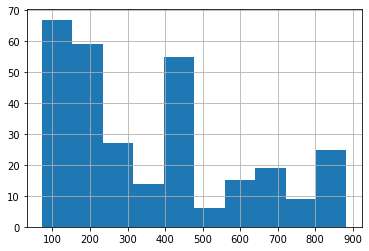

In [ ]:
df['Close'].hist()
print(df['Close'].mean())

# 1. 1変数が条件分岐の対象＆バイナリ化したい場合

In [ ]:
df['flg_open_800'] = df['Open'].apply(lambda x : 1 if x >= 800 else 0)
df.loc[df.Close >= 750].head()

,High,Low,Open,Close,Volume,Adj Close,flg_open_800
Date,,,,,,,
2021-01-06,774.000000,749.099976,758.489990,755.979980,44700000.0,755.979980,0
2021-01-07,816.989990,775.200012,777.630005,816.039978,51498900.0,816.039978,0
2021-01-08,884.489990,838.390015,856.000000,880.020020,75055500.0,880.020020,1
2021-01-11,854.429993,803.619995,849.400024,811.190002,59301600.0,811.190002,1
2021-01-12,868.000000,827.340027,831.000000,849.440002,46270700.0,849.440002,1


# 2. 1変数が条件分岐の対象&複数の状態に分岐させたい（カテゴリ化したい）


*  openが＄700未満→0 
*  openが＄700 から ＄800→1  
*  openが＄800 から ＄850→2  
*  openが＄850以上→3

In [ ]:
# 条件分岐の関数を定義
def func_cate(x):
    if  x < 700:
        return 0
    elif x >= 700 and x < 800:
        return 1
    elif x >= 800 and x < 850:
        return 2
    else:
        return 3

df['cate_f'] = df['Open'].apply(func_cate)
df.groupby('cate_f')['Volume'].count()

cate_f
0    258
1     12
2     14
3     12
Name: Volume, dtype: int64

# 3. 1変数が条件分岐の対象＆元の値を変換
- ＄500未満ならばNULLに置換

- ＄500以上＄600未満ならば＄550に置換

- ＄600以上ならopenの値そのまま  

In [ ]:
def func_open_2(x):
    if  x < 500:
        return np.NaN
    elif x >= 500 and x < 600:
        return 550
    else:
        return x

df['open_2'] = df['Open'].apply(func_open_2)

In [ ]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,flg_open_800,cate_f,open_2
Date,,,,,,,,,
2020-01-02,86.139999,84.342003,84.900002,86.052002,47660500.0,86.052002,0,0,NaN
2020-01-03,90.800003,87.384003,88.099998,88.601997,88892500.0,88.601997,0,0,NaN
2020-01-06,90.311996,88.000000,88.094002,90.307999,50665000.0,90.307999,0,0,NaN
2020-01-07,94.325996,90.671997,92.279999,93.811996,89410500.0,93.811996,0,0,NaN
2020-01-08,99.697998,93.646004,94.739998,98.428001,155721500.0,98.428001,0,0,NaN


# 4. 複数変数が条件分岐の対象＆カテゴリ化したい


*   openがcloseよりも低い（値上がり）→1
*   openがcloseよりも高い（値下がり）→2
*   openがcloseと同じ→0


In [ ]:
def func_cate_change(x):
    if x.Open < x.Close:
        return 1
    elif x.Open > x.Close:
        return 2
    else:
        return 0

df['cate_change'] = df.apply(lambda x:func_cate_change(x),axis=1)

In [ ]:
df.groupby('cate_change')['Volume'].count()

cate_change
1    147
2    149
Name: Volume, dtype: int64

# 5. 複数変数が条件分岐の対象＆値を加工する


*   highとlowが＄10以上離れているなら、openとcloseの平均を取る
*   highとlowが＄10円未満なら、highとlowの平均を取る



In [ ]:
def func_avg_10(x):
    if x.High - x.Low <= 10:
        return (x.High + x.Low) /2
    else:
        return (x.Open + x.Close) /2

df['avg_10'] = df.apply(lambda x:func_avg_10(x),axis=1)

In [ ]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,flg_open_800,cate_f,open_2,cate_change,avg_10
Date,,,,,,,,,,,
2020-01-02,86.139999,84.342003,84.900002,86.052002,47660500.0,86.052002,0,0,NaN,1,85.241001
2020-01-03,90.800003,87.384003,88.099998,88.601997,88892500.0,88.601997,0,0,NaN,1,89.092003
2020-01-06,90.311996,88.000000,88.094002,90.307999,50665000.0,90.307999,0,0,NaN,1,89.155998
2020-01-07,94.325996,90.671997,92.279999,93.811996,89410500.0,93.811996,0,0,NaN,1,92.498997
2020-01-08,99.697998,93.646004,94.739998,98.428001,155721500.0,98.428001,0,0,NaN,1,96.672001


# 6. 複数変数が条件分岐の対象＆外側から引数を与える

*   OpenがCloseに対して＋X円以上ならYを代入
*   OpenがCloseに対して＋X円未満ならZを代入



In [ ]:
def func_xyz(row,x,y,z):
    if row.Open >= x:
        return y
    else:
        return z

# x,y,zを事前に定義
x = 400
y = 0
z = 1
df['xyz'] = df.apply(lambda row:func_xyz(row,x,y,z),axis=1)

# 7. 複数変数が条件分岐の対象＆欠損値置換

*   値下がりする日(cate_change:1)のopen_2が欠損値ならば、期間全体の平均値を置換する
*   値上がりする日(cate_change:2)のopen_2が欠損値ならば、当日のopenを置換する
*   変動がない日(cate_change:0)のopen_2が欠損値ならば、そのままopen_2を採用する
*   欠損値でないならそのままopen_2を採用する






In [ ]:
import math

def func_open_3(row,avg_open):
    # スカラーでnp.NaNを評価したい場合は、mathで判定するのがいいっぽい
    if math.isnan(row.open_2):
        if row.cate_change == 1:
            return avg_open
        elif row.cate_change == 2:
            return row.Open
        else:
            return row.open_2
    else:
        return row.open_3

# 行に対する処理と列に対する処理を同時に行うのは困難なので、まず欠損値処理を行う
df['open_3'] = df.open_2.fillna(method='bfill')

# 列に対する処理を実施する前に、open_2の行方向の平均値を事前に計算しておく
avg_open = df['Open'].mean()

# 列方向に対する処理を行う
df['open_3'] = df.apply(lambda x: func_open_3(x,avg_open),axis=1)

In [ ]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,flg_open_800,cate_f,open_2,cate_change,avg_10,xyz,open_3
Date,,,,,,,,,,,,,
2020-01-02,86.139999,84.342003,84.900002,86.052002,47660500.0,86.052002,0,0,NaN,1,85.241001,1,362.813927
2020-01-03,90.800003,87.384003,88.099998,88.601997,88892500.0,88.601997,0,0,NaN,1,89.092003,1,362.813927
2020-01-06,90.311996,88.000000,88.094002,90.307999,50665000.0,90.307999,0,0,NaN,1,89.155998,1,362.813927
2020-01-07,94.325996,90.671997,92.279999,93.811996,89410500.0,93.811996,0,0,NaN,1,92.498997,1,362.813927
2020-01-08,99.697998,93.646004,94.739998,98.428001,155721500.0,98.428001,0,0,NaN,1,96.672001,1,362.813927
